# The Linear Classifier
```{eval-rst}
Last updated |lastupdate|
```

[![Open in Colab](https://img.shields.io/static/v1?logo=google-colab&message=Open%20in%20colab&color=blue&label=%20&labelColor=5c5c5c)](https://colab.research.google.com/github/vanvalenlab/bebi205/blob/master/bebi205/notebooks/linear-classifier.ipynb)
[![Open key in Colab](https://img.shields.io/static/v1?logo=google-colab&message=Open%20key%20in%20colab&color=blue&label=%20&labelColor=5c5c5c)](https://colab.research.google.com/github/vanvalenlab/bebi205/blob/master/bebi205/notebooks/linear-classifier-key.ipynb)

To illustrate the workflow for training a deep learning model in a supervised manner, this notebook will walk you through the simple case of training a linear classifier to recognize images of cats and dogs. While deep learning might seem intimidating, dont worry. Its conceptual underpinnings are rooted in linear algebra and calculus - if you can perform matrix multiplication and take derivatives you can understand what is happening in a deep learning workflow.

Some code cells will be marked with
```
##########################
######## To Do ###########
##########################
```

This indicates that you are being asked to write a piece of code to complete the notebook.

## Load packages
In this cell, we load the python packages we need for this notebook.

In [3]:
import imageio
import skimage
import sklearn.model_selection
import skimage.color
import skimage.transform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## The supervised machine learning workflow
Recall from class the conceptual workflow for a supervised machine learning project.
- First, we create a <em>training dataset</em>, a paired collection of raw data and labels where the labels contain information about the "insight" we wish to extract from the raw data.
- Once we have training data, we can then use it to train a <em>model</em>. The model is a mathematical black box - it takes in data and transforms it into an output. The model has some parameters that we can adjust to change how it performs this mapping.
- Adjusting these parameters to produce outputs that we want is called training the model. To do this we need two things. First, we need a notion of what we want the output to look like. This notion is captured by a <em>loss function</em>, which compares model outputs and labels and produces a score telling us if the model did a "good" job or not on our given task. By convention, low values of the loss function's output (e.g. the loss) correspond to good performance and high values to bad performance. We also need an <em>optimization algorithm</em>, which is a set of rules for how to adjust the model parameters to reduce the loss
- Using the training data, loss function, and optimization algorithm, we can then train the model
- Once the model is trained, we need to evaluate its performance to see how well it performs and what kinds of mistakes it makes. We can also perform this kind of monitoring during training (this is actually a standard practice).

Because this workflow defines the lifecycle of most machine learning projects, this notebook is structured to go over each of these steps while constructing a linear classifier.


## Create training data
The starting point of every machine learning project is data. In this case, we will start with a collection of RGB images of cats and dogs. Each image is a multi-dimensional array with size (128, 128, 1) - the first two dimensions are spatial while the last is a channel dimension (one channel because it is a grey scale image - for an RGB image there would be 3 channels). The dataset that we are working with is a subset of [Kaggle's Dogs vs. Cats dataset](https://www.kaggle.com/c/dogs-vs-cats/overview).

In [4]:
!curl -O https://storage.googleapis.com/datasets-spring2021/cats-and-dogs-bw.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  7  684M    7 53.8M    0     0  58.5M      0  0:00:11 --:--:--  0:00:11 58.5M
 20  684M   20  142M    0     0  74.3M      0  0:00:09  0:00:01  0:00:08 74.3M
 37  684M   37  254M    0     0  86.9M      0  0:00:07  0:00:02  0:00:05 86.9M
 52  684M   52  359M    0     0  91.8M      0  0:00:07  0:00:03  0:00:04 91.8M
 67  684M   67  462M    0     0  93.9M      0  0:00:07  0:00:04  0:00:03 93.9M
 81  684M   81  556M    0     0  93.9M      0  0:00:07  0:00:05  0:00:02  100M
 96  684M   96  660M    0     0  95.3M      0  0:00:07  0:00:06  0:00:01  103M
100  684M  100  684M    0     0  95.8M      0  0:00:07  0:00:07 --:--:--  102M


In [5]:
# Load data from the downloaded npz file
with np.load('cats-and-dogs-bw.npz') as f:
    X = f['X']
    y = f['y']

print(X.shape, y.shape)

(8192, 128, 128, 1) (8192,)


In the previous cell, you probably observed that there are 4 dimensions rather than the 3 you might have been expecting. This is because while each image is (128, 128, 1), the full dataset has many images. The different images are stacked along the first dimension. The full size of the training images is (# images, 128, 128, 1) - the first dimension is often called the batch dimension.

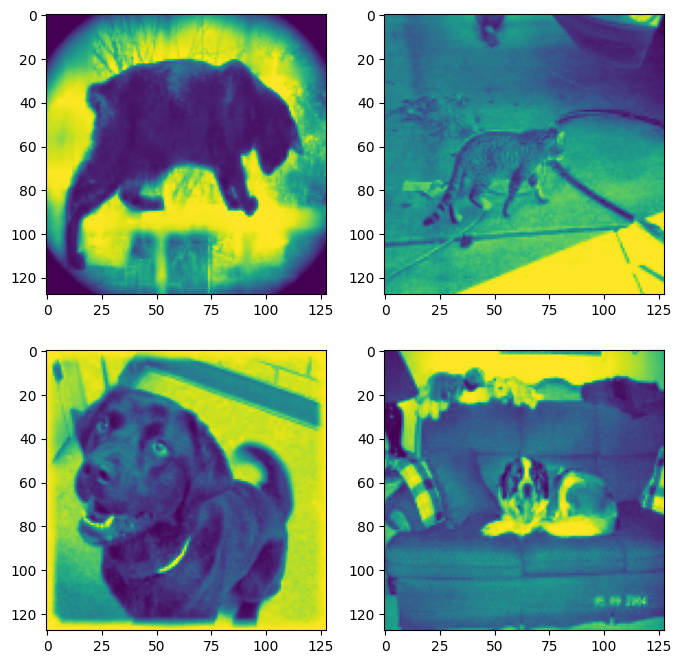

In [6]:
##########################
######## To Do ###########
##########################

# Use matplotlib to visualze several images randomly drawn from the dataset
# For each image, set the title to be the y label for the image
imgs = X[np.random.choice(X.shape[0], 4, replace=False)]

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(imgs[0])
plt.subplot(222)
plt.imshow(imgs[1])
plt.subplot(223)
plt.imshow(imgs[2])
plt.subplot(224)
plt.imshow(imgs[3])



For this exercise, we will want to flatten the training data into a vector.

In [7]:
# Flatten the images into vectors of size (# images, 16384, 1)
X = np.reshape(X, (-1, 128*128, 1))
print(X.shape)

(8192, 16384, 1)


### Split the training dataset into training, validation, and testing datasets
How do we know how well our model is doing? A common practice to evaluate models is to evaluate them on splits of the original training dataset. Splitting the data is important, because we want to see how models perform on data that wasn't used to train them. This splitting practice usually produces 3 splits.
- The <em>training</em> dataset used to train the model
- A <em>validation </em> dataset used to evaluate the model during training.
- A held out <em>testing</em> dataset used to evaluate the final trained version of the model
While there is no hard and fast rule, 80%, 10%, 10% splits are a reasonable starting point.

In [8]:
# Split the dataset into training, validation, and testing splits
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75)

## The linear classifier
The linear classifier produces class scores that are a linear function of the pixel values. Mathematically, this can be written as $\vec{y} = W \vec{x}$, where $\vec{y}$ is the vector of class scores, $W$ is a matrix of weights and $\vec{x}$ is the image vector. The shape of the weights matrix is determined by the number of classes and the length of the image vector. In this case $W$ is 2 by 4096. Our learning task is to find a set of weights that maximize our performance on our classification task. We will solve this task by doing the following steps
- Randomly initializing a set of weights
- Defining a loss function that measures our performance on the classification task
- Use stochastic gradient descent to find "optimal" weights

### Create the matrix of weights
Properly initializing weights is essential for getting deep learning methods to work correctly. The two most common initialization methods you'll see in this class are [glorot uniform (also known as Xavier) initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf?hc_location=ufi]) and [he initialization](http://openaccess.thecvf.com/content_iccv_2015/html/He_Delving_Deep_into_ICCV_2015_paper.html) - both papers are worth reading. For this exercise, we will randomly initialize weights by using glorot uniform initialization. In this initialization method, we sample our weights according to the formula
\begin{equation}
W_{ij} \sim U\left[ -\frac{1}{\sqrt{n}}, \frac{1}{\sqrt{n}} \right],
\end{equation}
where $n$ is the number of columns in the weight matrix (4096 in our case).

Lets create the linear classifier using object oriented programming, which will help with organization

In [32]:
class LinearClassifier(object):
    def __init__(self, image_size=16384):
        self.image_size=image_size

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):

        ##########################
        ######## To Do ###########
        ##########################

        init = 1/np.sqrt(self.image_size)

        # Randomly initialize the weights matrix acccording to the glorot uniform initialization
        self.W = np.random.uniform(-init, init, size=(2, self.image_size))


### Apply the softmax transform to complete the model outputs
Our LinearClassifier class needs a method to perform predictions - which in our case is performing matrix multiplication and then applying the softmax transform. Recall from class that the softmax transform is given by
\begin{equation}
softmax(y_i) = \frac{e^{y_i}}{\sum_j e^{y_j}}
\end{equation}
and provides a convenient way to convert our class scores into probabilities

In [56]:
##########################
######## To Do ###########
##########################

# Complete the predict function below to predict a label y from an input X
# Pay careful attention to the shape of your data at each step

def predict(self, X, epsilon=1e-5):
    y = np.matmul(X[...,0], self.W.T)
    print(X.shape, X[...,0].shape)
    print(self.W.shape)
    print(y.shape)

    sm_y = (np.exp(y)) / (np.sum(np.exp(y)))# Apply softmax
    return sm_y

# Assign methods to class
setattr(LinearClassifier, 'predict', predict)

Now lets see what happens when we try to predict the class of images in our training dataset using randomly initialized weights.

(2, 16384) [[ 0.00732386  0.00780428 -0.00386547 ...  0.00335692  0.00216577
   0.00769834]
 [ 0.00770802  0.00020332  0.00025846 ...  0.00603818 -0.00515397
   0.00301499]]
(1, 16384, 1) (1, 16384)
(2, 16384)
(1, 2)
(1, 16384, 1) (1, 16384)
(2, 16384)
(1, 2)
(1, 16384, 1) (1, 16384)
(2, 16384)
(1, 2)
(1, 16384, 1) (1, 16384)
(2, 16384)
(1, 2)
(1, 16384, 1) (1, 16384)
(2, 16384)
(1, 2)
(1, 16384, 1) (1, 16384)
(2, 16384)
(1, 2)
(1, 16384, 1) (1, 16384)
(2, 16384)
(1, 2)
(1, 16384, 1) (1, 16384)
(2, 16384)
(1, 2)


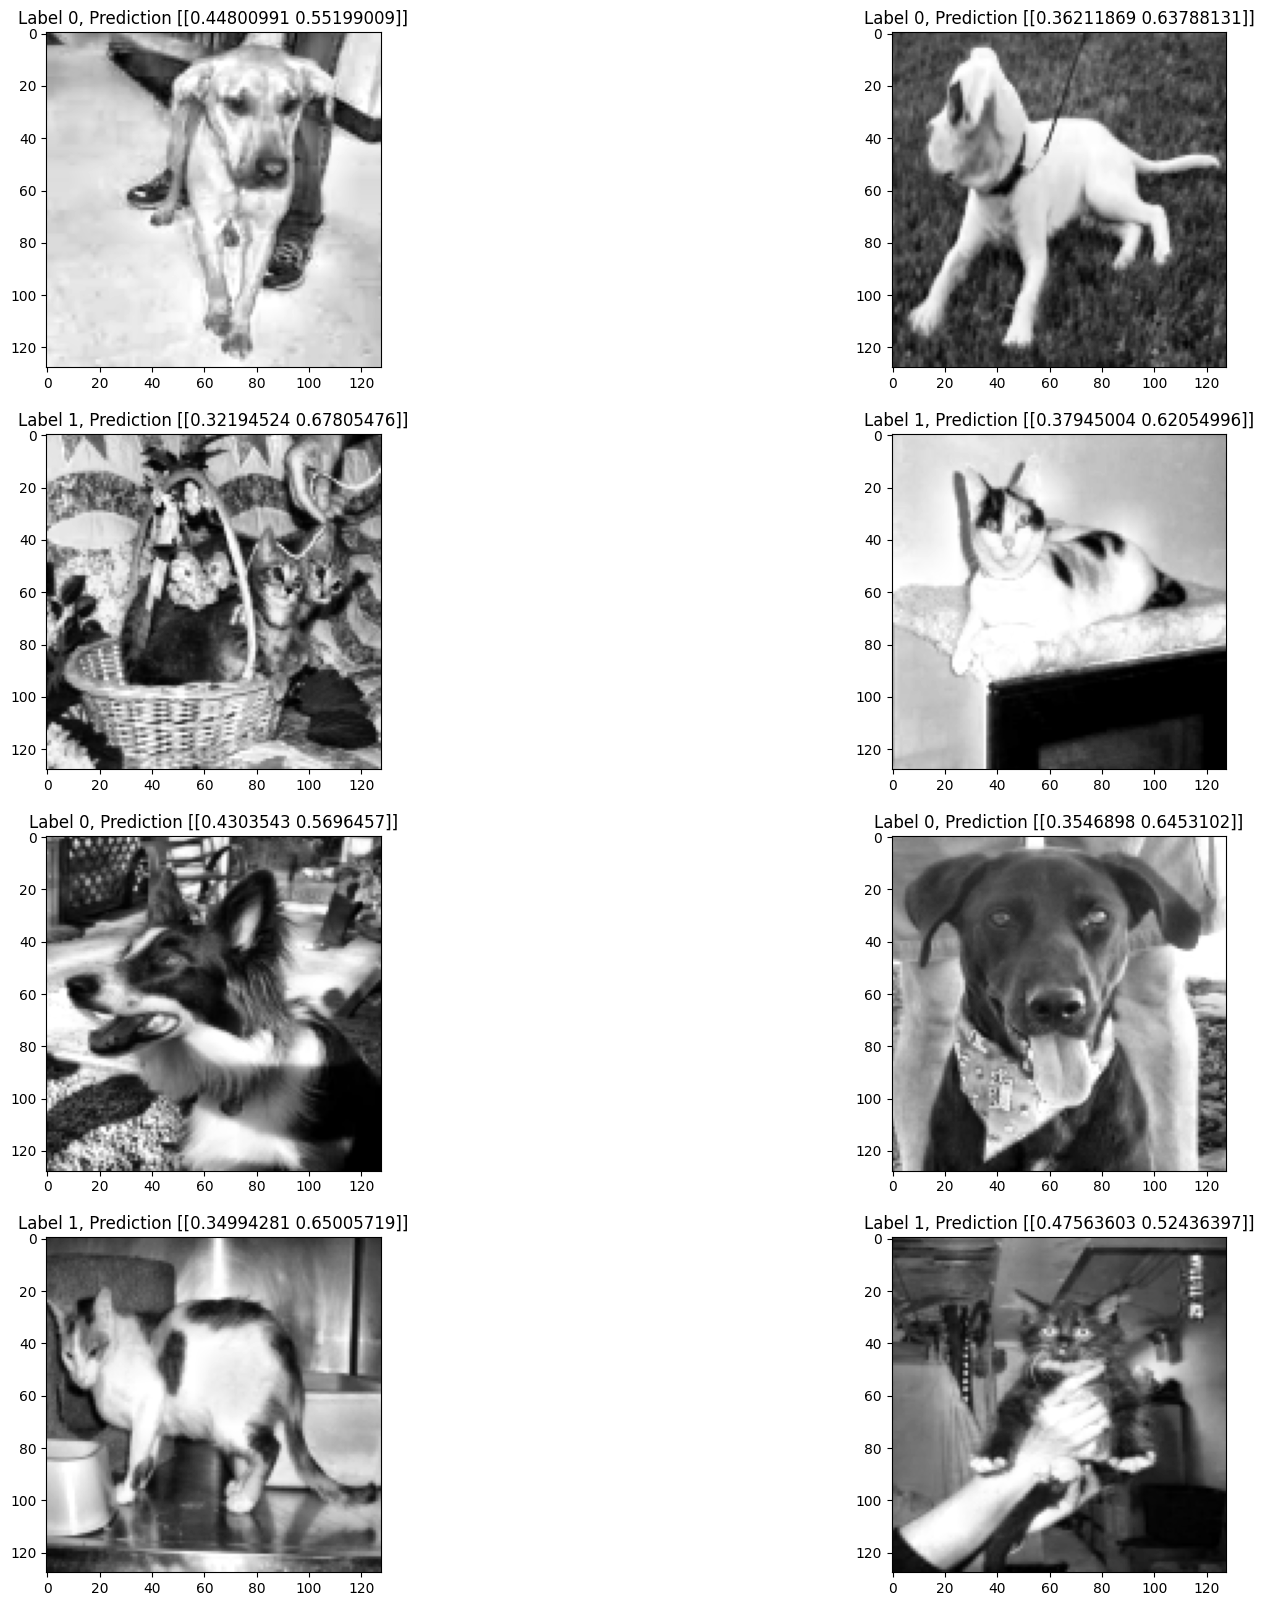

In [57]:
lc = LinearClassifier()

fig, axes = plt.subplots(4, 2, figsize=(20,20))
for i in range(8):

    # Get an example image
    X_sample = X[[i],...]

    # Reshape flattened vector to image
    X_reshape = np.reshape(X_sample, (128,128))

    # Predict the label
    y_pred = lc.predict(X_sample)
    #print(y_pred.shape)

    # Display results
    axes.flatten()[i].imshow(X_reshape, cmap='gray')
    axes.flatten()[i].set_title('Label ' + str(y[i]) +', Prediction ' + str(y_pred))

What do you notice about the initial results of the model?

## Stochastic gradient descent
To train this model, we will use stochastic gradient descent. In its simplest version, this algorithm consists of the following steps:
- Select several images from the training dataset at random
- Compute the gradient of the loss function with respect to the weights, given the selected images
- Update the weights using the update rule $\Delta W_{ij} \rightarrow \Delta W_{ij} - lr\frac{\partial loss}{\partial W_{ij}}$

Recall that the origin of this update rule is from multivariable calculus - the gradient tells us the direction in which the loss function increases the most. So to minimize the loss function we move in the opposite direction of the gradient.

Also recall from the course notes that for this problem we can compute the gradient analytically. The gradient is given by

\begin{equation}
\frac{\partial loss}{\partial W_{ij}} = \left(p_i - 1(i \mbox{ is correct}) \right)x_j,
\end{equation}
where $1$ is an indicator function that is 1 if the statement inside the parentheses is true and 0 if it is false.

In [60]:
def grad(self, X, y):
    # Get class probabilities
    p = self.predict(X)
    
    # Compute class 0 gradients
    temp_0 = np.expand_dims(p[...,0] - (1-y), axis=-1)
    grad_0 = temp_0 * X[...,0]

    # Compute class 1 gradients
    temp_1 = np.expand_dims(p[...,1] - y, axis=-1)
    grad_1 =  temp_1 * X[...,0]
    
    gradient = np.stack([grad_0, grad_1], axis=1)
    
    return gradient
    
def loss(self, X, y_true):
    y_pred = self.predict(X)
    
    # Convert y_true to one hot
    y_true = np.stack([y_true, 1-y_true], axis=-1)
    loss = np.mean(-y_true * np.log(y_pred))
    
    return loss
    
def fit(self, X_train, y_train, n_epochs, batch_size=1, learning_rate=1e-5):
    # Iterate over epochs
    for epoch in range(n_epochs):
        n_batches = int(np.floor(X_train.shape[0] / batch_size))
        
        # Generate random index
        index = np.arange(X_train.shape[0])
        np.random.shuffle(index)
        
        # Iterate over batches
        loss_list = []
        for batch in range(n_batches):
            beg = batch*batch_size
            end = (batch+1)*batch_size if (batch+1)*batch_size < X_train.shape[0] else -1
            X_batch = X_train[beg:end]
            y_batch = y_train[beg:end]
            
            # Compute the loss
            loss = self.loss(X_batch, y_batch)
            loss_list.append(loss)
            
            # Compute the gradient
            gradient = self.grad(X_batch, y_batch)
            
            # Compute the mean gradient over all the example images
            gradient = np.mean(gradient, axis=0, keepdims=False)

            # Update the weights
            self.W -= learning_rate * gradient
            
        return loss_list

# Assign methods to class
setattr(LinearClassifier, 'grad', grad)
setattr(LinearClassifier, 'loss', loss)
setattr(LinearClassifier, 'fit', fit)

lc = LinearClassifier()
loss = lc.fit(X_train, y_train, n_epochs=10, batch_size=16)

(2, 16384) [[-0.00119528  0.00385895 -0.00049907 ... -0.0030373   0.00701975
  -0.0056065 ]
 [ 0.00385401  0.00011962 -0.0065114  ...  0.00472096 -0.00556786
   0.00712359]]
(16, 16384, 1) (16, 16384)
(2, 16384)
(16, 2)
(16, 16384, 1) (16, 16384)
(2, 16384)
(16, 2)
(16, 16384, 1) (16, 16384)
(2, 16384)
(16, 2)
(16, 16384, 1) (16, 16384)
(2, 16384)
(16, 2)
(16, 16384, 1) (16, 16384)
(2, 16384)
(16, 2)
(16, 16384, 1) (16, 16384)
(2, 16384)
(16, 2)
(16, 16384, 1) (16, 16384)
(2, 16384)
(16, 2)
(16, 16384, 1) (16, 16384)
(2, 16384)
(16, 2)
(16, 16384, 1) (16, 16384)
(2, 16384)
(16, 2)
(16, 16384, 1) (16, 16384)
(2, 16384)
(16, 2)
(16, 16384, 1) (16, 16384)
(2, 16384)
(16, 2)
(16, 16384, 1) (16, 16384)
(2, 16384)
(16, 2)
(16, 16384, 1) (16, 16384)
(2, 16384)
(16, 2)
(16, 16384, 1) (16, 16384)
(2, 16384)
(16, 2)
(16, 16384, 1) (16, 16384)
(2, 16384)
(16, 2)
(16, 16384, 1) (16, 16384)
(2, 16384)
(16, 2)
(16, 16384, 1) (16, 16384)
(2, 16384)
(16, 2)
(16, 16384, 1) (16, 16384)
(2, 16384)
(16, 2

## Evaluate the model
Benchmarking performance is a critical part of the model development process. For this problem, we will use 3 different benchmarks
- Recall: the fraction of positive examples detected by a model. Mathematically, for a two-class classification problem, recall is calculated as (True positives)/(True positives + False negatives).
- Precision: the percentage of positive predictions from a model that are true. Mathematically, for a two-class prediction problem, precision is calculated as (True positives)/(True positives + False positives).
- F1 score: The harmonic mean between the recall and precision

We will evaluate these metrics on both the training dataset (the examples used during training) and our testing dataset (the examples that we held out). We can also use a confusion matrix to visualize the prediction results.

(1, 16384, 1) (1, 16384)
(2, 16384)
(1, 2)
(1, 16384, 1) (1, 16384)
(2, 16384)
(1, 2)
(1, 16384, 1) (1, 16384)
(2, 16384)
(1, 2)
(1, 16384, 1) (1, 16384)
(2, 16384)
(1, 2)
(1, 16384, 1) (1, 16384)
(2, 16384)
(1, 2)
(1, 16384, 1) (1, 16384)
(2, 16384)
(1, 2)
(1, 16384, 1) (1, 16384)
(2, 16384)
(1, 2)
(1, 16384, 1) (1, 16384)
(2, 16384)
(1, 2)


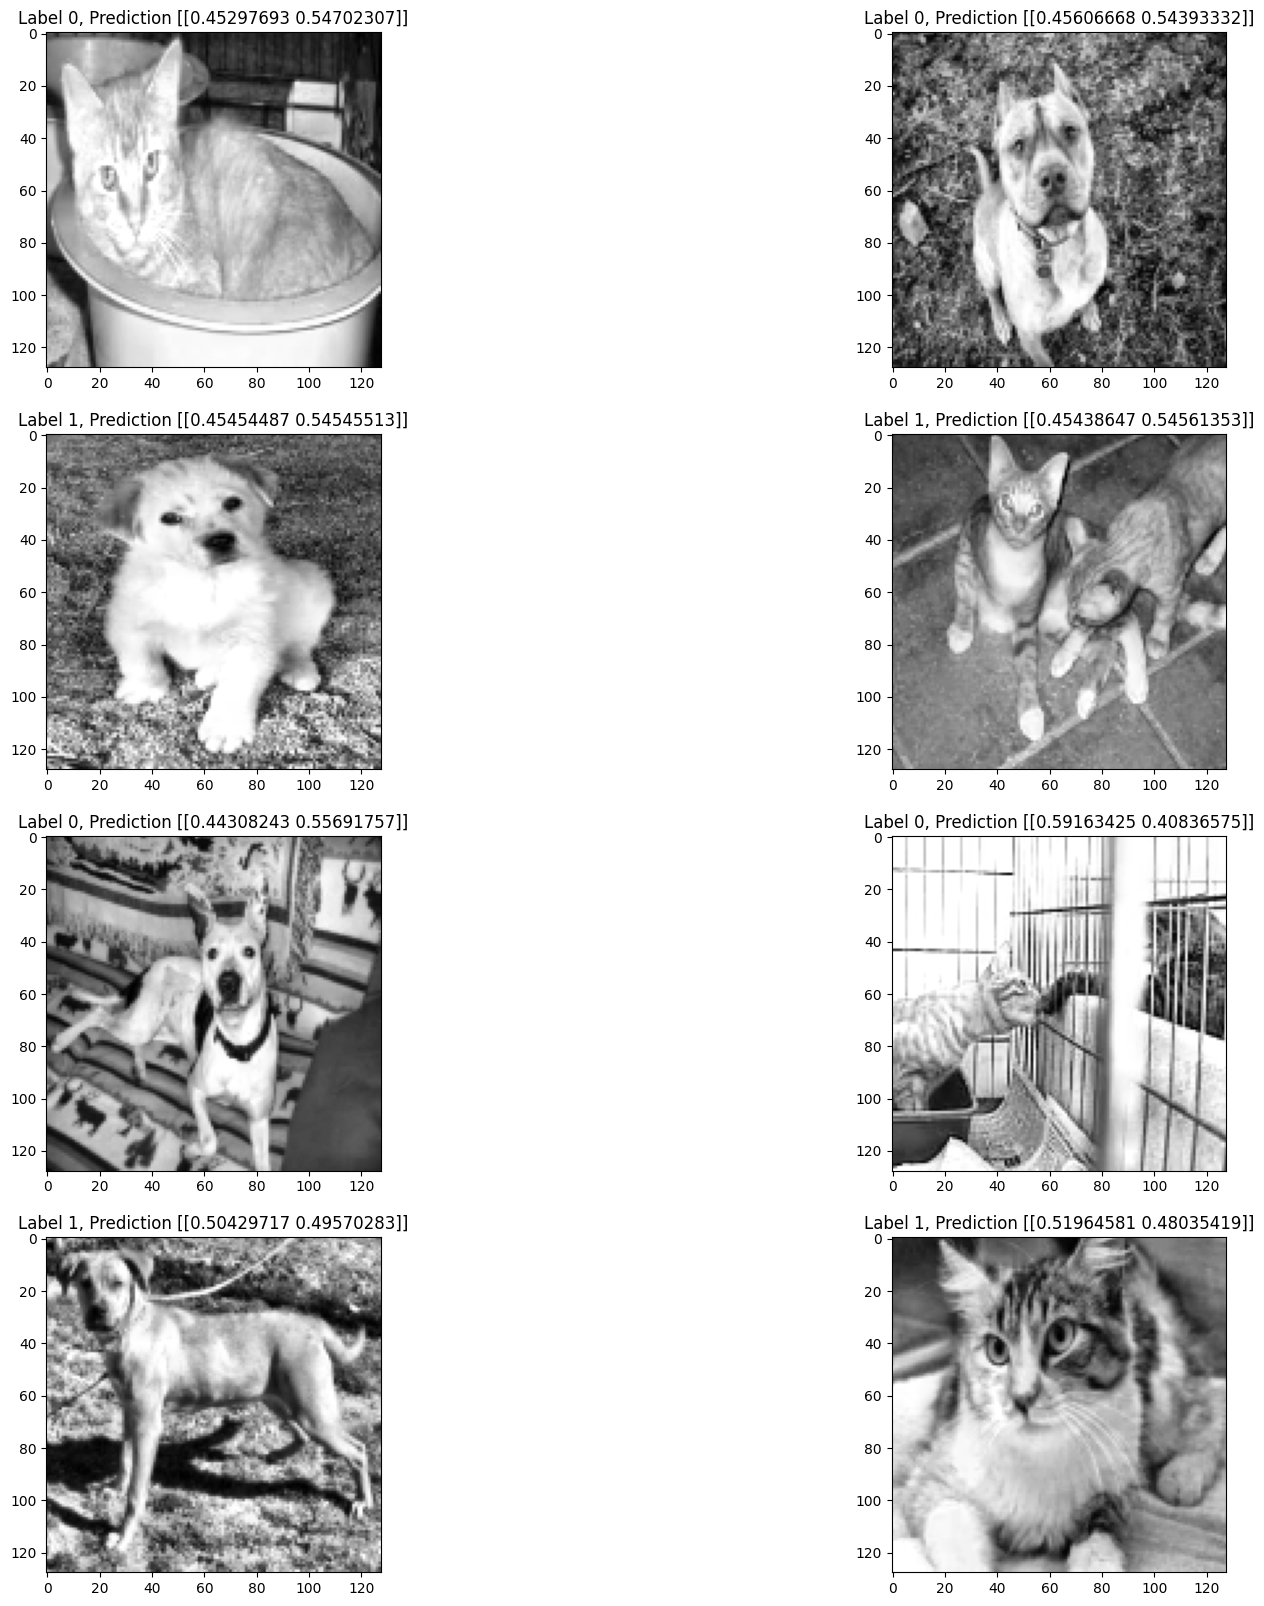

In [61]:
# Visualize some predictions

fig, axes = plt.subplots(4, 2, figsize=(20,20))
for i in range(8):

    # Get an example image
    X_sample = X_test[[i],...]

    # Reshape flattened vector to image
    X_reshape = np.reshape(X_sample, (128,128))

    # Predict the label
    y_pred = lc.predict(X_sample)

    # Display results
    axes.flatten()[i].imshow(X_reshape, cmap='gray')
    axes.flatten()[i].set_title('Label ' + str(y[i]) +', Prediction ' + str(y_pred))

In [62]:
# Generate predictions
y_pred = lc.predict(X_train)
y_pred = np.argmax(y_pred, axis=-1)

# Compute metrics
recall = sklearn.metrics.recall_score(y_train, y_pred)
precision = sklearn.metrics.precision_score(y_train, y_pred)
f1 = sklearn.metrics.f1_score(y_train, y_pred)

print('Training Recall: {}'.format(recall))
print('Training Precision: {}'.format(precision))
print('Training F1 Score: {}'.format(f1))

# Generate predictions
y_pred = lc.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)

# Compute metrics
recall = sklearn.metrics.recall_score(y_test, y_pred)
precision = sklearn.metrics.precision_score(y_test, y_pred)
f1 = sklearn.metrics.f1_score(y_test, y_pred)

print('Testing Recall: {}'.format(recall))
print('Testing Precision: {}'.format(precision))
print('Testing F1 Score: {}'.format(f1))


(6144, 16384, 1) (6144, 16384)
(2, 16384)
(6144, 2)
Training Recall: 0.3642668428005284
Training Precision: 0.5285098227120268
Training F1 Score: 0.43128054740957966
(2048, 16384, 1) (2048, 16384)
(2, 16384)
(2048, 2)
Testing Recall: 0.34925093632958804
Testing Precision: 0.5253521126760563
Testing F1 Score: 0.41957255343082117


## Exercise
Try running your training algorithm a few times and record the results. What do you note about the overall performance? What about the differences between training runs? What about the difference in performance when evaluated on training data as opposed to validation data?